In [17]:
import numpy as np
import pandas as pd
import os
import json
import torch
from torchvision import models
from torch import nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import cv2


In [18]:
ROOT = 'Datasets'
TRAIN_IMAGES_PATH = os.path.join(ROOT, 'train_images')

# Load the CSV file
train_df = pd.read_csv(os.path.join(ROOT, 'train.csv'))

# Create image paths
train_df['path'] = TRAIN_IMAGES_PATH + '/' + train_df['image_id']
train_df.head(10)

image_id  label                                  path
0  1000015157.jpg      0  Datasets/train_images/1000015157.jpg
1  1000201771.jpg      3  Datasets/train_images/1000201771.jpg
2   100042118.jpg      1   Datasets/train_images/100042118.jpg
3  1000723321.jpg      1  Datasets/train_images/1000723321.jpg
4  1000812911.jpg      3  Datasets/train_images/1000812911.jpg
5  1000837476.jpg      3  Datasets/train_images/1000837476.jpg
6  1000910826.jpg      2  Datasets/train_images/1000910826.jpg
7  1001320321.jpg      0  Datasets/train_images/1001320321.jpg
8  1001723730.jpg      4  Datasets/train_images/1001723730.jpg
9  1001742395.jpg      3  Datasets/train_images/1001742395.jpg

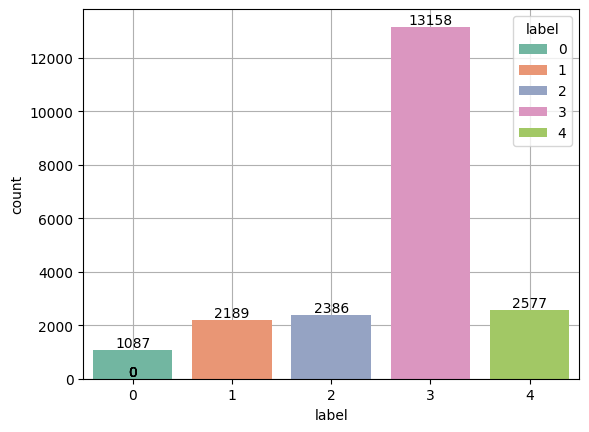

In [19]:
ax = sns.countplot(train_df , x = 'label', hue= "label",palette = "Set2")
# Loop through each bar in the countplot
for p in ax.patches:
    # Get the height of the bar (which represents the count)
    height = p.get_height()
    # Place a text above each bar
    # The first argument of `ax.text()` is the x position, which is the center of the bar
    # The second argument is the y position, which we set slightly above the bar
    # The third argument is the text we want to display, which is the height of the bar converted to string
    ax.text(p.get_x() + p.get_width() / 2., height + 100, int(height), ha='center')

ax.set_axisbelow(True)
plt.grid()
plt.show()

In [20]:
with open(ROOT + "/label_num_to_disease_map.json", "r") as f:
    print(json.dumps(json.loads(f.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [21]:
def show_leaf_disease_pre(label):
    sample = train_df[train_df.label == label].sample(6)
    plt.figure(figsize=(10,10))
    for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
        plt.subplot(3, 3, ind + 1)
        image = cv2.imread(os.path.join(TRAIN_IMAGES_PATH, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

In [22]:
#Cassava Bacterial Blight (CBB)
#show_leaf_disease_pre(0)

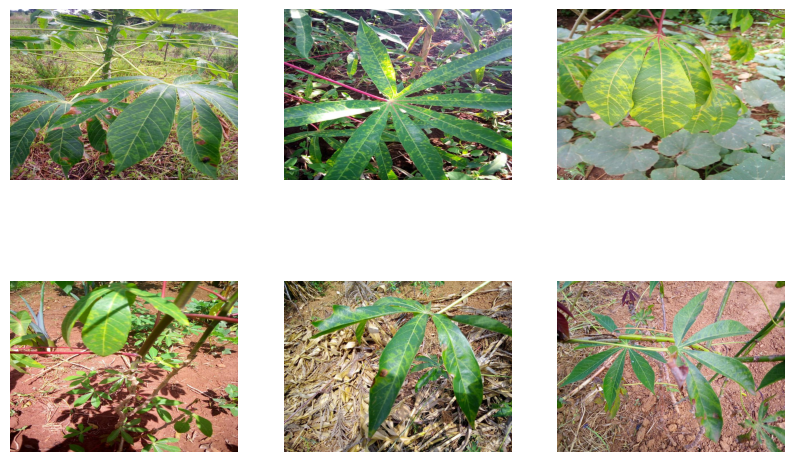

In [23]:
#Cassava Brown Streak Disease (CBSD)
show_leaf_disease_pre(1)

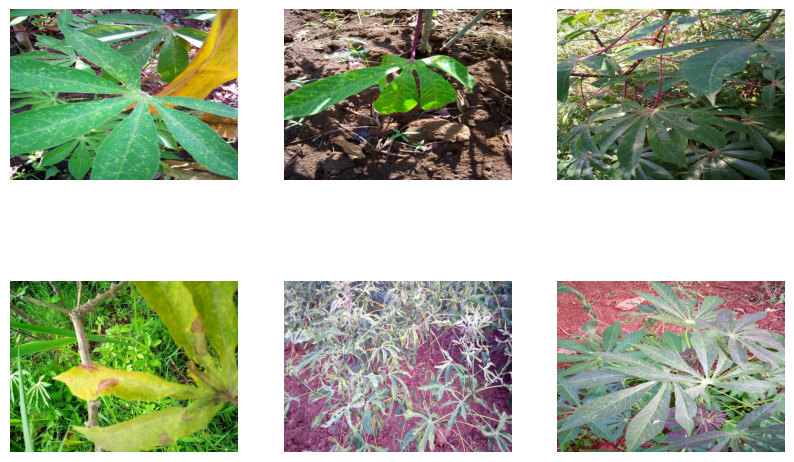

In [24]:
#Cassava Green Mottle (CGM)
show_leaf_disease_pre(2)

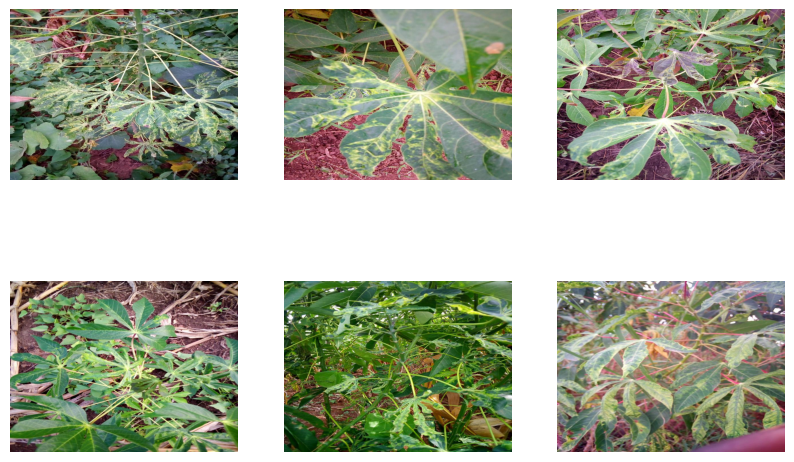

In [25]:
#Cassava Mosaic Disease (CMD)
show_leaf_disease_pre(3)

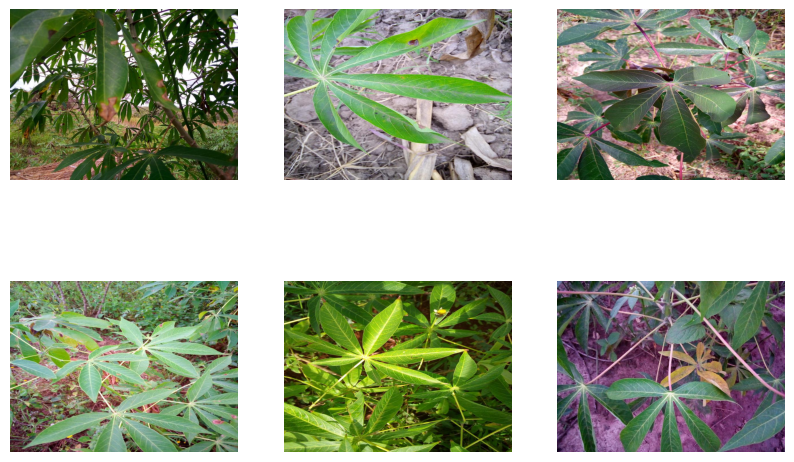

In [26]:
#healthy leaf
show_leaf_disease_pre(4)

In [27]:
class CassavaDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)  # Reset the index
        #self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #print("index is " , index)
        if index >= len(self.df):
            raise IndexError('Index out of range')
        img = Image.open(self.df['path'][index])
        #img = np.array(img)
        label = torch.tensor(self.df['label'][index], dtype=torch.long)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


In [28]:

# Count the number of non-existent files
train_df['is_exists'] = train_df['path'].apply(lambda x: os.path.exists(x))
n_not_exists = train_df[train_df['is_exists'] == False].shape[0]

# Raise an assertion error if there are non-existent files
assert n_not_exists == 0, f'There are {n_not_exists} non-existent files'

# Count the number of images (existent files)
n_images = train_df[train_df['is_exists'] == True].shape[0]
print(f'Total images: {n_images}')

# Display the first 20 rows of the DataFrame
train_df.head(10)

In [ ]:
from sklearn.model_selection import StratifiedKFold
sk = StratifiedKFold(n_splits=4, random_state=23, shuffle=True)

for fold, (train, val) in enumerate(sk.split(train_df, train_df.label)):
    train_df.loc[val, 'fold'] = fold
train_df.fold = train_df.fold.astype(int)


In [ ]:
train_df.fold = train_df.fold.astype(int)

In [ ]:
train_df['fold']

0        0
1        1
2        3
3        0
4        1
        ..
21392    2
21393    3
21394    1
21395    0
21396    3
Name: fold, Length: 21397, dtype: int64

In [ ]:
WIDTH = 512
HEIGHT = 512
NUM_CLASSES = 5
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {DEVICE}')

Device: cuda


In [ ]:
transform =  transforms.Compose([
    transforms.RandomResizedCrop((WIDTH, HEIGHT)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
])

n_images = len(train_df)
n_train = int(n_images * 0.8)  # 60% of the dataset
n_val = n_images - n_train  # 20% of the dataset
#n_test = n_images - n_train - n_val  # The remaining 20%

dataset = CassavaDataset(train_df, transform=transform)

train_df, val_df= random_split(
    dataset, 
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)  # Seed for reproducibility
)

print('Splitted dataset:')
print(f'\t- Training set: {len(train_df)}')
print(f'\t- Validation set: {len(val_df)}')
#print(f'\t- Testing set: {len(test_df)}')

Splitted dataset:
	- Training set: 17117
	- Validation set: 4280


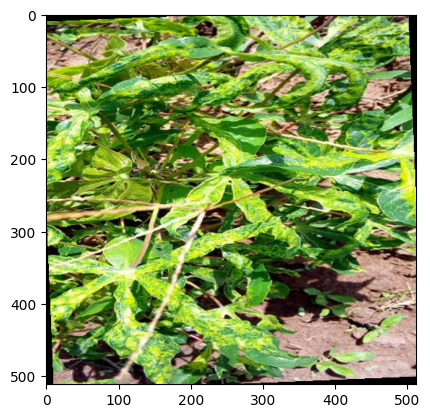

In [ ]:
#sample transformed pictures
plt.imshow(dataset[21][0].numpy().transpose(1,2,0))



In [ ]:
dataset[2][0].shape

torch.Size([3, 600, 800])

In [ ]:
train_dl = DataLoader(train_df, BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_df, BATCH_SIZE, shuffle=True)
#test_dl = DataLoader(test_df, BATCH_SIZE, shuffle=True)

In [ ]:
for item in train_dl:
    print(item)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

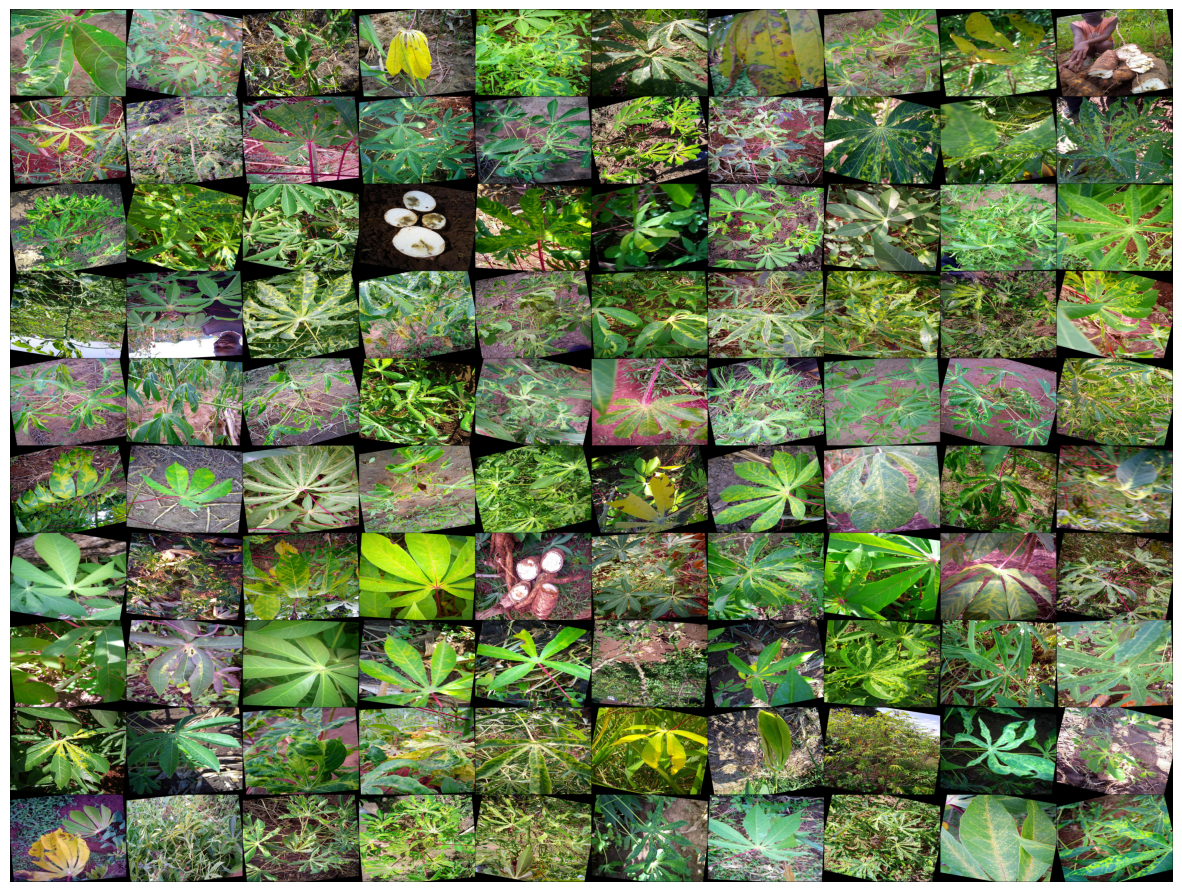

In [ ]:
from torchvision.utils import make_grid
def plot_images(images, nrow=10, figsize=(15, 15)):
    grid_img = make_grid(images, nrow=nrow)
    plt.figure(figsize=figsize)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Collect 100 images
def collect_images(dataloader, num_images=100):
    collected_images = []
    for images, _ in dataloader:
        collected_images.extend(images)
        if len(collected_images) >= num_images:
            break
    return collected_images[:num_images]

# Assuming 'your_dataloader' is defined and holds your dataset
# Uncomment the next line and replace 'your_dataloader' with your actual DataLoader
collected_images = collect_images(train_dl)

# Plot the collected images
plot_images(torch.stack(collected_images))

In [23]:
import timm
def get_model(name):
    
    if name =="resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False
            in_feat = model.fc.in_features
        
        model.fc = nn.Sequential(
              nn.Linear(in_feat, 256),
              nn.ReLU(),
              nn.Dropout(p=0.3),
              nn.Linear(256, NUM_CLASSES))
        
    elif name =="efficient":
        model = timm.create_model('tf_efficientnet_b4_ns', pretrained=True)
        for param in model.parameters():
            param.requires_grad = False

        num_classes = 5  
        classifier_input_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(classifier_input_features, num_classes) 
        )
    
    elif name == "vit":
        model = timm.create_model("vit_base_patch16_224", pretrained=True)
        num_classes = 5  
        classifier_input_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(classifier_input_features, num_classes) 
        )
    
    elif name =="tf_efficientnet_lite0":
        model = timm.create_model("tf_efficientnet_lite0", pretrained=True)
        num_classes = 5  
        classifier_input_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(classifier_input_features, num_classes) 
        )

    model = model.to(DEVICE)
    
    return model


In [24]:
model = get_model("tf_efficientnet_lite0")

summary(model, input_size=(BATCH_SIZE, 3, WIDTH, HEIGHT))

/home/uceezw9/.conda/envs/aml2/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [64, 5]                   --
├─Conv2dSame: 1-1                             [64, 48, 256, 256]        (1,296)
├─BatchNormAct2d: 1-2                         [64, 48, 256, 256]        96
│    └─Identity: 2-1                          [64, 48, 256, 256]        --
│    └─SiLU: 2-2                              [64, 48, 256, 256]        --
├─Sequential: 1-3                             [64, 448, 16, 16]         --
│    └─Sequential: 2-3                        [64, 24, 256, 256]        --
│    │    └─DepthwiseSeparableConv: 3-1       [64, 24, 256, 256]        (2,940)
│    │    └─DepthwiseSeparableConv: 3-2       [64, 24, 256, 256]        (1,206)
│    └─Sequential: 2-4                        [64, 32, 128, 128]        --
│    │    └─InvertedResidual: 3-3             [64, 32, 128, 128]        (11,878)
│    │    └─InvertedResidual: 3-4             [64, 32, 128, 128]        (1

In [ ]:
num_epochs = 10
patience = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)


In [ ]:
import copy
from tqdm import tqdm 
from rich.progress import Progress

def train(model, num_epochs, train_dl, valid_dl):
    
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_valid_loss = np.inf
    
    with Progress() as progress:
        training_task = progress.add_task("[red]Training...", total=num_epochs*len(train_dl))
        
        for epoch in range(num_epochs):
            
            model.train()
            
            batch_num = 0
            
            for x_batch, y_batch in train_dl:
                
                progress.update(training_task, advance=1)
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                
                batch_num += 1
                #if (batch_num % 100 == 0):
                    #print(f'Batch number: {batch_num}')
                
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                loss_hist_train[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_train[epoch] += is_correct.sum().item()
            
            
            loss_hist_train[epoch] /= len(train_dl.dataset)
            accuracy_hist_train[epoch] /= len(train_dl.dataset)
            
            scheduler.step()
            
            model.eval()
            
            with torch.no_grad():
                
                for x_batch, y_batch in valid_dl:
                    
                    x_batch = x_batch.to(DEVICE)
                    y_batch = y_batch.to(DEVICE)
                    
                    pred = model(x_batch)
                    loss = loss_fn(pred, y_batch)
                    loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                    is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                    accuracy_hist_valid[epoch] += is_correct.sum().item()
                    
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
            
            if accuracy_hist_valid[epoch] > best_acc:
                best_acc = accuracy_hist_valid[epoch]
                best_model_wts = copy.deepcopy(model.state_dict())
            
            print(f'Epoch {epoch+1}:   Train accuracy: {accuracy_hist_train[epoch]:.4f}    Validation accuracy: {accuracy_hist_valid[epoch]:.4f} ')
        
        
            if loss_hist_valid[epoch] < min_valid_loss:
                counter = 0
            else:
                counter += 1
        
            if counter >= patience:
                break
    
    torch.save(best_model_wts, 'B/best_model.pth')
    model.load_state_dict(best_model_wts)
    
    history = {}
    history['loss_hist_train'] = loss_hist_train
    history['loss_hist_valid'] = loss_hist_valid
    history['accuracy_hist_train'] = accuracy_hist_train
    history['accuracy_hist_valid'] = accuracy_hist_valid
    
    return model, history

In [ ]:
best_model, hist = train(model, num_epochs, train_dl, val_dl)

Output()

Epoch 1:   Train accuracy: 0.7790    Validation accuracy: 0.7967

Epoch 2:   Train accuracy: 0.7881    Validation accuracy: 0.8072

In [ ]:
label_list = []
prediction_list = []

with torch.no_grad():
    for image, label in tqdm(test_dl):
        
        image = image.to(DEVICE)
        logits = best_model(image)
        probs = torch.nn.functional.softmax(logits, dim=1).detach().cpu().numpy()
        prediction = np.argmax(probs, axis=1)
        label_list += label.numpy().tolist()
        prediction_list += prediction.tolist()

100%|██████████| 67/67 [01:53<00:00,  1.70s/it]


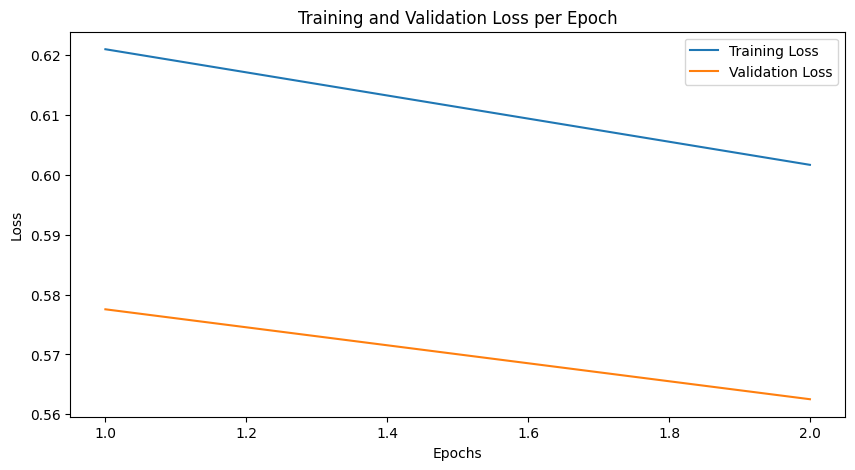

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is a dictionary that contains loss values for training and validation
# And also assuming that the number of epochs is contained in the length of the loss lists

epochs = list(range(1, len(hist['loss_hist_train']) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, hist['loss_hist_train'], label='Training Loss')
plt.plot(epochs, hist['loss_hist_valid'], label='Validation Loss')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(label_list, prediction_list))


              precision    recall  f1-score   support

           0       0.50      0.40      0.44       188
           1       0.61      0.62      0.61       417
           2       0.68      0.61      0.64       490
           3       0.90      0.94      0.92      2681
           4       0.62      0.60      0.61       504

    accuracy                           0.80      4280
   macro avg       0.66      0.63      0.65      4280
weighted avg       0.80      0.80      0.80      4280



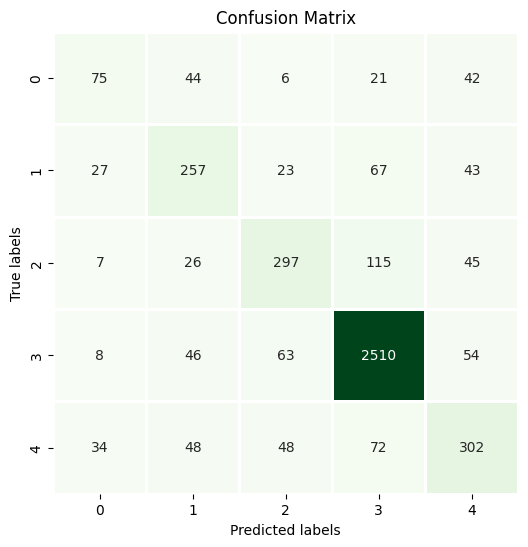

In [ ]:
cm = confusion_matrix(label_list, prediction_list)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, linewidth=1, linecolor='white')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()